In [1]:
from features import *
from detection import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import csv
import pandas as pd
import sklearn.utils
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

All the code for the feature extraction part of the car detection can be down in `features.py`.

Three main features were extracted:

1. Spatial features
2. Color histogram
3. Histogram of Orientated Gradients

The spatial provides us information of the spatial location of the pixels in the image. The color histogram features gives gives insight in the color distribution of the image, and finally the HOG features yields details on the edges and shape of the cars. All three of these features combined are important features to help the classifier distinguing car from non-car images.

A sample of car and non-car images along with their three features were compared below

Binned color features shape (768,)
Color histogram features shape (48,)
HOG features shape (1764,)


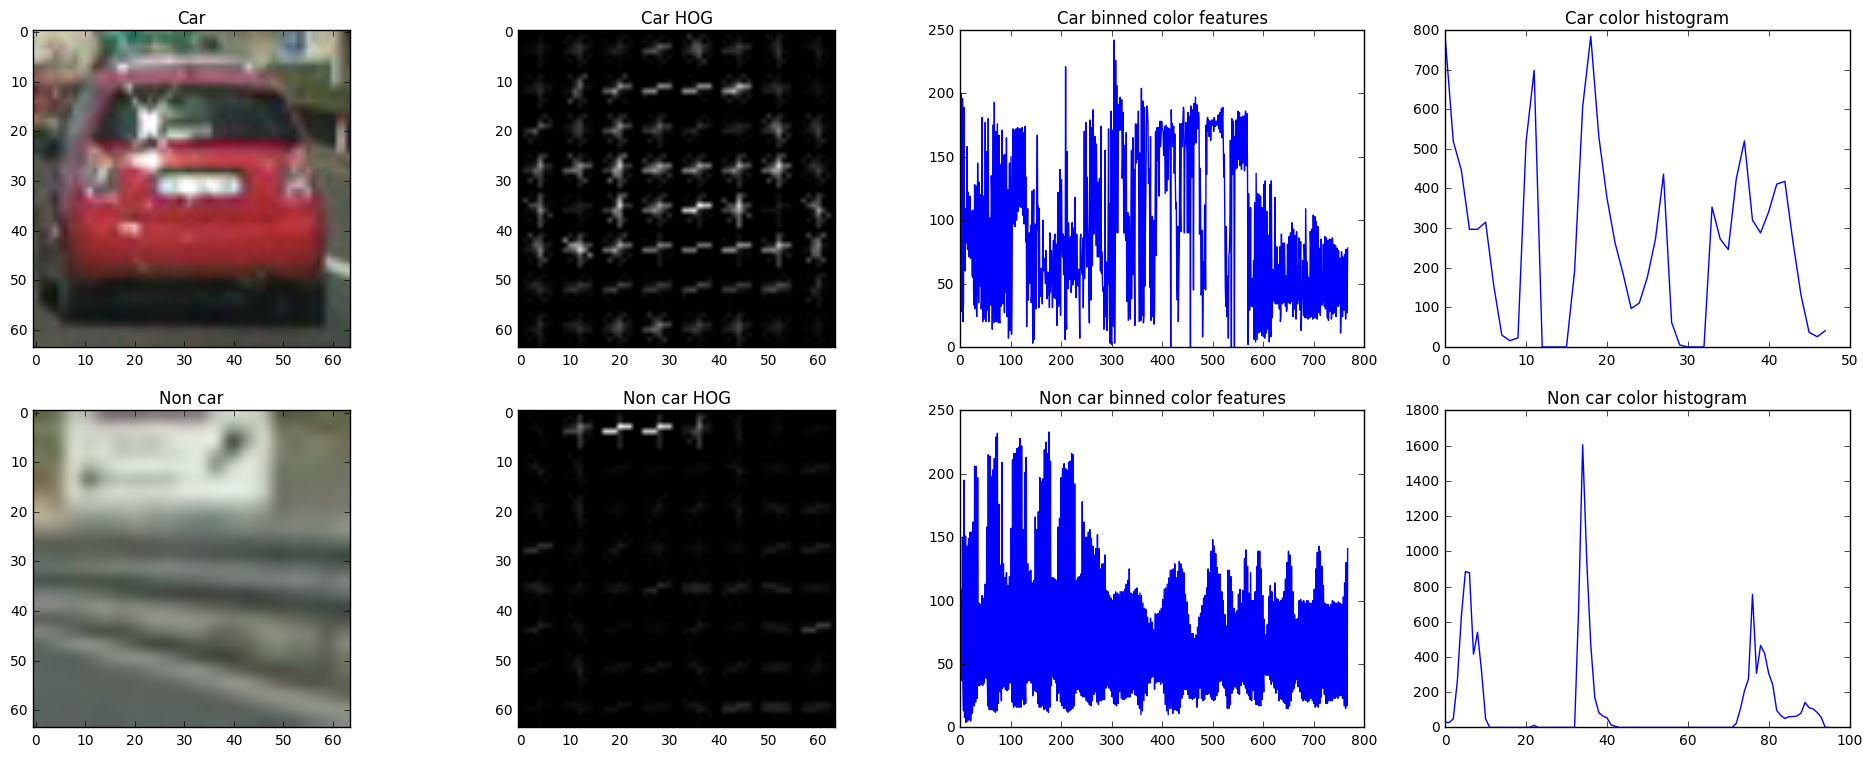

In [22]:
img = mpimg.imread('./vehicles/GTI_MiddleClose/image0190.png', format=np.uint8)
noncar_img = mpimg.imread('./non-vehicles/GTI/image119.png', format=np.uint8)

cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
cvt_noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2HSV)
# HOG
orientation = 9
px_per_cell = 8
cell_per_block = 2

# Color histogram
nbins = 16
bins_range = (0, 256)
spatial_size = (16, 16)

bin_features = bin_spatial(cvt_img, size=spatial_size)
color_features = color_hist(cvt_img, nbins=nbins, bins_range=bins_range)
hog_features, hog_img = get_hog_features(cvt_img[:, :, 0], orientation, pix_per_cell=px_per_cell, cell_per_block=cell_per_block,
                                     vis=True, feature_vec=True)

print("Binned color features shape", bin_features.shape)
print("Color histogram features shape", color_features.shape)
print("HOG features shape", hog_features.shape)


bin_noncar_features = bin_spatial(cvt_noncar_img, size=spatial_size)
color_noncar_features = color_hist(cvt_noncar_img, nbins=32, bins_range=bins_range)
noncar_hog_features, noncar_hog_img = get_hog_features(cvt_noncar_img[:, :, 0], orientation, pix_per_cell=px_per_cell, cell_per_block=cell_per_block,
                                     vis=True, feature_vec=True)

f, axarr = plt.subplots(2, 4, figsize=(24, 9))

axarr[0][0].imshow(img)
axarr[0][0].set_title("Car")
axarr[1][0].imshow(noncar_img)
axarr[1][0].set_title("Non car")

axarr[0][1].imshow(hog_img, cmap='gray')
axarr[0][1].set_title("Car HOG")
axarr[0][2].plot(bin_features)
axarr[0][2].set_title("Car binned color features")
axarr[0][3].plot(color_features)
axarr[0][3].set_title("Car color histogram")

axarr[1][1].imshow(noncar_hog_img, cmap='gray')
axarr[1][1].set_title("Non car HOG")
axarr[1][2].plot(bin_noncar_features)
axarr[1][2].set_title("Non car binned color features")
axarr[1][3].plot(color_noncar_features)
axarr[1][3].set_title("Non car color histogram")

### 2. Explain how you settled on your final choice of HOG parameters.

After experimenting with various combination of values, the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`.

Not only did the output yield good results in the classification of cars, but it has a good number of elements in the feature vector, i.e. 2580 features. Having a higher dimensionality makes the training of the classifier much more slower.

### 3. Preparing the data

For training the model, the GTI dataset which contains various images of cars and non-cars examples with ground truth labels. The data is written to a csv file and then loaded to pandas for easily manipulation of the files.

In [ ]:
def write_csv(data_folder, dst_folder):
    
    train_files = list(glob.glob(data_folder + '/*/*.png'))
    labels = [path.split('/')[1] for path in train_files]
    imgtype = [path.split('/')[2] for path in train_files]
    
    image_names = [path.split('/')[-1] for path in train_files]
    
    # save csv
    dst_file = data_folder.split('/')[-1] + ".csv"
    csv_file = dst_folder + "/" + dst_file
    with open(csv_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(['image_path', 'image_name', 'label', 'image_type'])
        for index, feature in enumerate(train_files):
            writer.writerow([train_files[index], image_names[index], labels[index], imgtype[index]])
            
    print("Saved:", csv_file)

### Write CSV

In [ ]:
data_vehicles_folder = "./vehicles"
data_non_vehicles_folder = "./non-vehicles"
dst_folder = "./"

write_csv(data_vehicles_folder, dst_folder)
write_csv(data_non_vehicles_folder, dst_folder)

### Load and visualize data

After writing the csv file, the data is loaded using pandas. It can be seen that there is an approximately equal amount of positive and negative samples (cars vs non-car images). The dataset also contains car images from different angles. The dataset images are explored further below.

In [4]:
vehicles = pd.read_csv('./vehicles.csv')
nonvehicles = pd.read_csv('./non-vehicles.csv')

print("Number of vehicle images:", vehicles.shape[0])
print("Nubmer of non-vehicle images:", nonvehicles.shape[0])

data = pd.concat((vehicles, nonvehicles), ignore_index=True)
#data = sklearn.utils.shuffle(data)
data.head()

Number of vehicle images: 8792
Nubmer of non-vehicle images: 8968


image_path     image_name     label image_type
0  ./vehicles/GTI_Right/image0600.png  image0600.png  vehicles  GTI_Right
1  ./vehicles/GTI_Right/image0829.png  image0829.png  vehicles  GTI_Right
2  ./vehicles/GTI_Right/image0699.png  image0699.png  vehicles  GTI_Right
3  ./vehicles/GTI_Right/image0268.png  image0268.png  vehicles  GTI_Right
4  ./vehicles/GTI_Right/image0875.png  image0875.png  vehicles  GTI_Right

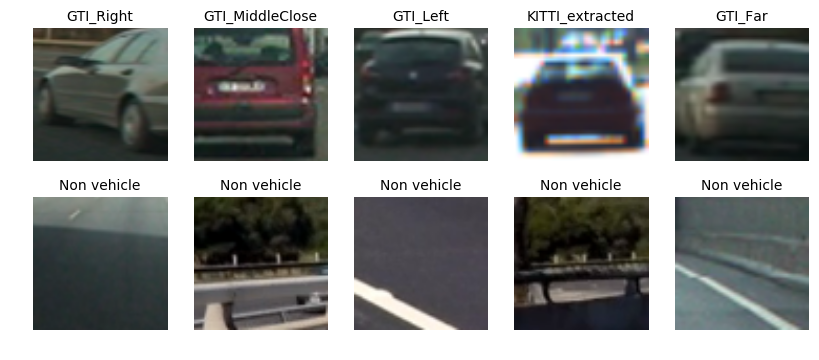

In [5]:
classes = data['label'].unique()
num_classes = len(classes)
types = vehicles['image_type'].unique()
num_types = len(types)
img_per_row = 5
plt.figure(figsize=(10, 4))

for i, img_type in enumerate(types):
    plt.subplot(num_classes, img_per_row, i + 1)
    imgpath = vehicles.loc[(vehicles['image_type'] == img_type) & (vehicles['label'] == 'vehicles')].sample(1)['image_path']
    img = mpimg.imread(imgpath.values[0])
    plt.imshow(img)
    plt.title("{}".format(img_type), fontsize=10)
    plt.axis('off') 
    
for i in range(5, 10):
    plt.subplot(num_classes, img_per_row, i + 1)
    imgpath = data.loc[(data['label'] == 'non-vehicles')].sample(1)['image_path']
    img = mpimg.imread(imgpath.values[0])
    plt.imshow(img)
    plt.title("Non vehicle", fontsize=10)
    plt.axis('off')     

### Extract features

We extract features for the entire dataset with the parameters that we previously determined were the best.

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(vehicles['image_path'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
                        
notcar_features = extract_features(nonvehicles['image_path'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#labels = np.array(data['label'])
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
features = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(features)
# Apply the scaler to X
features_scaled = X_scaler.transform(features)

### PCA dimension reduction

PCA is performed to reduce the dimensionality of the data. This helps a good amount to deal with the high dimensionality of data which slows down the training time significantly. The choice of 25 components were kept, as the explained variance plateaus after 25 principal components as seen below.

Total explained variance by 25 principal components: 0.3932
CPU times: user 4.69 s, sys: 244 ms, total: 4.94 s
Wall time: 2.16 s


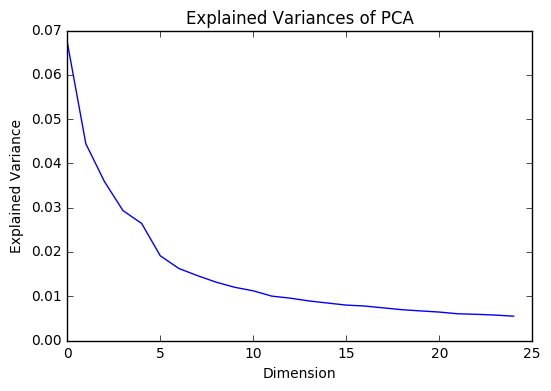

In [7]:
%%time

from sklearn.decomposition import RandomizedPCA, PCA

n_components = 25

pca = PCA(n_components=n_components, whiten=True)
pca = pca.fit(features_scaled)
pca_features = pca.transform(features_scaled)

explained_variance = pca.explained_variance_ratio_
components = pca.components_

print("Total explained variance by {} principal components: {:.4f}".format(n_components, sum(explained_variance[:n_components])))

# plot pca
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.title("Explained Variances of PCA")
_ = plt.plot(pca.explained_variance_ratio_)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.20, random_state=42) 

print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)

Training data: (14208, 25)
Testing data: (3552, 25)


In [9]:
data_dict = {}
data_dict['features_scaled'] = features_scaled
data_dict['labels'] = labels
data_dict['spatial_feat'] = spatial_feat
data_dict['hist_feat'] = hist_feat
data_dict['hog_feat'] = hog_feat
data_dict['orient'] = orient
data_dict['color_space'] = color_space 
data_dict['pix_per_cell'] = pix_per_cell
data_dict['cell_per_block'] = cell_per_block
data_dict['hog_channel'] = hog_channel
data_dict['spatial_size'] = spatial_size
data_dict['hist_bins'] = hist_bins
data_dict['pca'] = pca
data_dict['scaler'] = X_scaler

save_file = './pca_data.pkl'

with open(save_file, 'wb') as f:
    pickle.dump(data_dict, f)

### Train classifier

The SVM classifier with the rbf kernel was used which allows to learn more complex, non-linear data. The data is also pre-processed with z-score normalization using sklearn's StandardScaler.

In [10]:
%%time

from sklearn.svm import SVC

clf_svc = SVC(kernel='rbf', class_weight='balanced', probability=True, C=10, gamma=0.1)
clf_svc.fit(X_train, y_train)
print(clf_svc)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 18.9 s, sys: 296 ms, total: 19.2 s
Wall time: 19.4 s


In [11]:
from sklearn.externals import joblib

fn = './vehicle_vs_non_vehicle_model_svcrbf_pca.pkl'
joblib.dump(clf_svc, fn) 

print('model saved')

model saved


In [12]:
%%time
acc = clf_svc.score(X_test, y_test)
print('Accuracy on test data is {}'.format(acc))

#predictions = clf_svc.predict(X_test)

Accuracy on test data is 0.9960585585585585
CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 386 ms


# Sliding Window Search

We use a sliding window search to find the car in the camera image. Specific locations are searched depending on if the car is close, mid and far range of the camera's perspective. The search space is visualized below in green bounding boxes, with the detected car in blue.

Cars between pixels 400 and 500 on the y direction appear smaller since they are further from the car, hence this area will be searched with a smaller window size. As we reach close and mid range, the window size is increased along with the start of the x and y locations since we want to maximize the range of search.

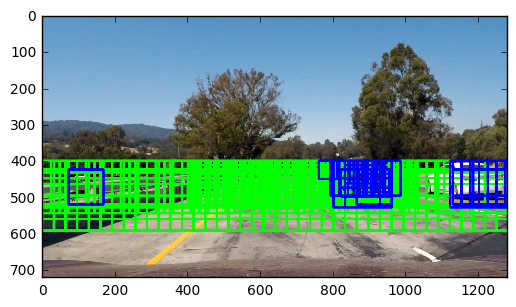

In [233]:
#img = mpimg.imread('./bbox-example-image.jpg', format=np.uint8)
img = mpimg.imread('./test_images/test1.jpg', format=np.uint8)

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 500]
window_size = (50, 50)
xy_overlap=(0.75, 0.75)
x_start_stop = [400, 1000]

y_start_stop_list = [[450, 580], [500, 720], [500, 720]]# Min and max in y to search in slide_window()
window_list = [(50, 50), (96, 96), (200, 200)]
windows = []

search_dict = {
    'far': [[[50, 50]], [[400, 500]], [[400, 1000]]],
    'mid': [[[96, 96]], [[400, 500]], [[None, None]]],
    'close': [[[128, 128]], [[400, 550]], [[None, None]]],
#    'very-close': [[[150, 150]], [[400, None]], [[None, None]]],
}

for item, param in search_dict.items():
    for window_size, y_start_stop, x_start_stop in zip(param[0], param[1], param[2]):
        windows_to_search = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=window_size, xy_overlap=xy_overlap)

    windows += windows_to_search

#windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                       xy_window=window_size, xy_overlap=xy_overlap)

X_scaler = StandardScaler().fit(features)

hot_windows = search_windows(img, windows, clf_svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, pca_feat=True, pca=pca)                       

draw_image = img.copy()
draw_image = draw_boxes(draw_image, windows, color=(0, 255, 0), thick=6)                    
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Heat map to remove multiple detections

To remove multiple detections, a heat map is used to represent regions that were detected with a car. A threshold is applied to ensure that only regions that were detected multiple times are kept. This first ensures to remove the multiple detections, but also removes the false positives.

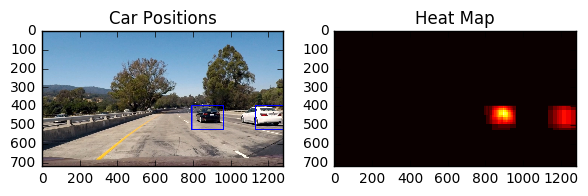

In [234]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

fig.tight_layout()


### Putting it all together

Now that the best parameters were determined, all the detection code was encapsualted under the CarDetector() class. The object holds all the different parameters of the car detection pipeline.

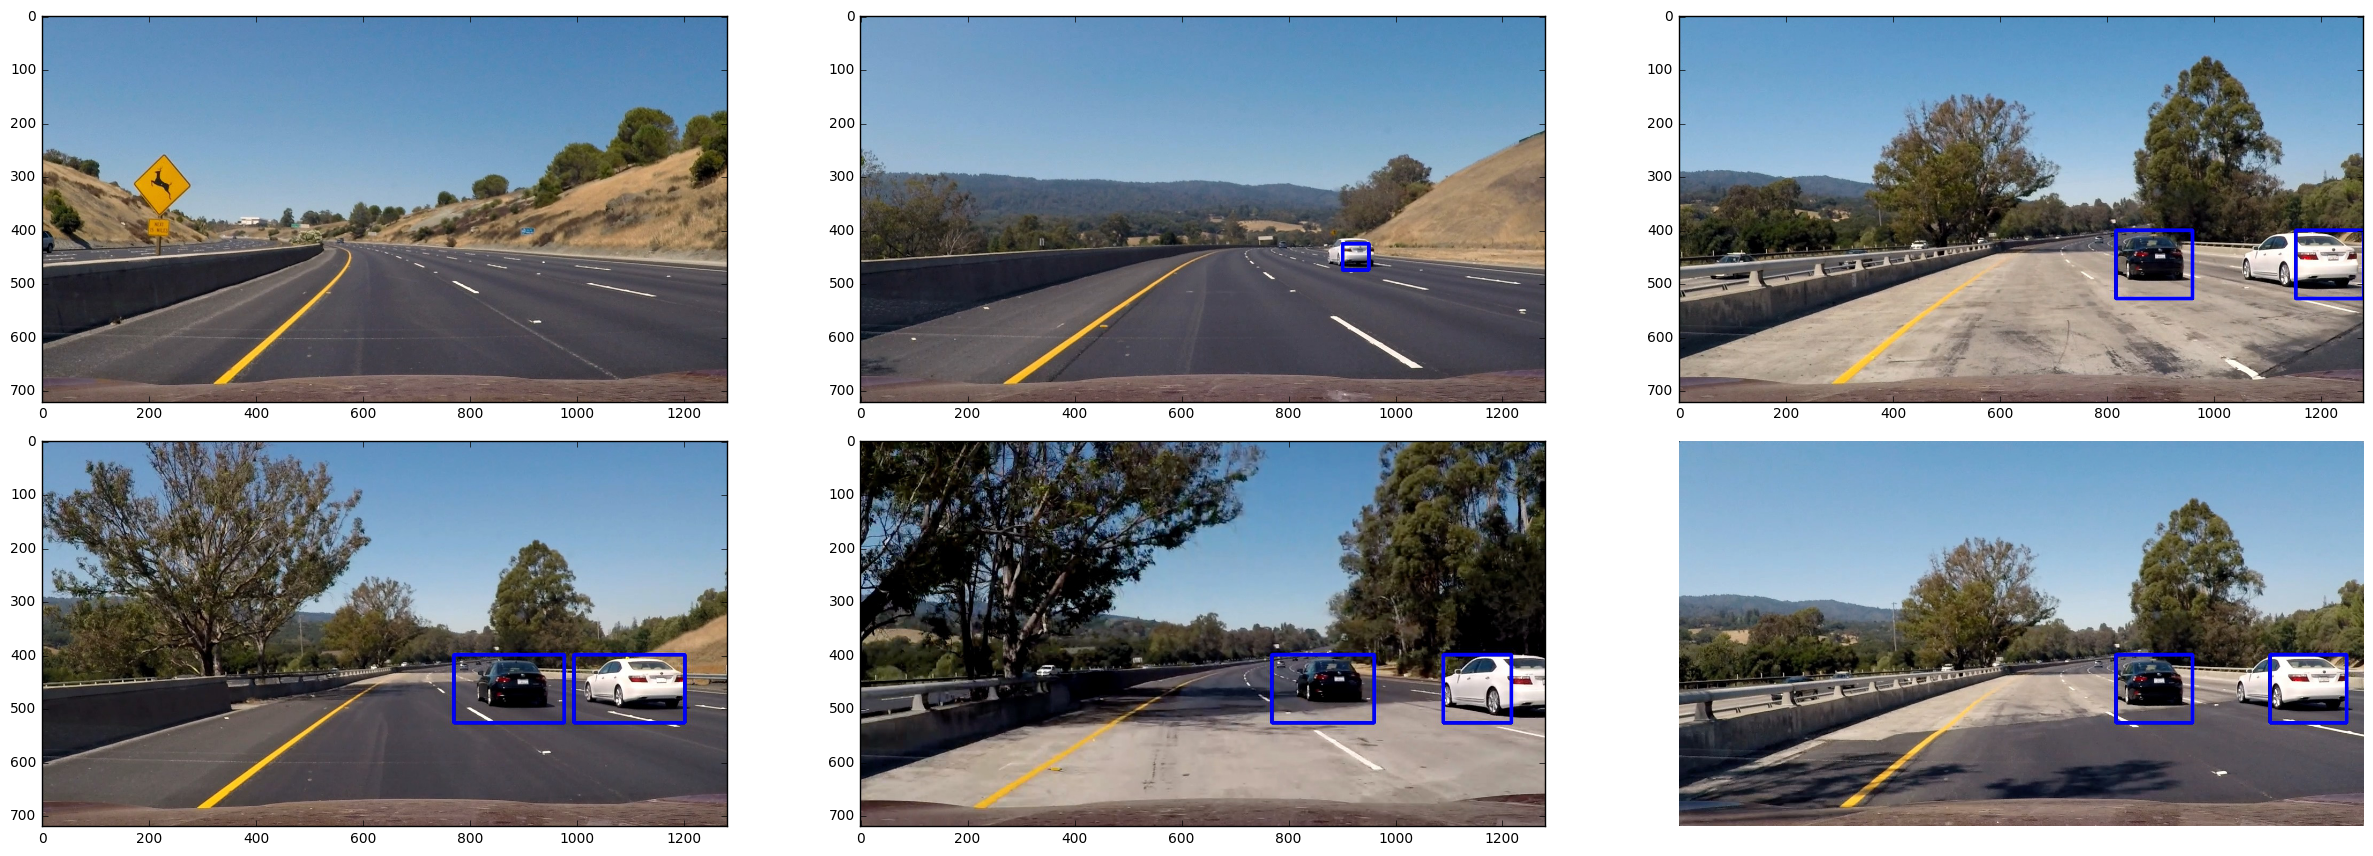

In [241]:
#img = mpimg.imread('./bbox-example-image.jpg', format=np.uint8)
img = mpimg.imread('./test_images/test1.jpg', format=np.uint8)

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
heat_thresh = 1

car_detector = CarDetector(clf_svc, pca, X_scaler, color_space=color_space, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                          spatial_size=spatial_size, hist_bins=hist_bins, spatial_feat=spatial_feat,
                          hist_feat=hist_feat, hog_feat=hog_feat, heat_thresh=heat_thresh)

# Run the pipeline on the test images
images = glob.glob('./test_images/*.jpg')
for fname in images:

    img = mpimg.imread(fname)
    #print(fname)
    output_image = car_detector.pipeline(img)
    mpimg.imsave('output_images/output_{}'.format(fname.split("/")[2]), output_image)
    
f, axarr = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()

output_images = glob.glob('./output_images/*.jpg')
out_imgs = [mpimg.imread(img) for img in output_images]

for i in range(2):
    for j in range(3):
        axarr[i, j].imshow(out_imgs[i * 3 + j])
plt.axis('off')     
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Test on video

In [235]:
from moviepy.editor import VideoFileClip

car_detector = CarDetector(clf_svc, pca, X_scaler)

project_output = 'project_output.mp4'
clip = VideoFileClip('./project_video.mp4')
outclip = clip.fl_image(car_detector.pipeline)
%time outclip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [07:47<00:00,  2.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 7min 35s, sys: 2.88 s, total: 7min 38s
Wall time: 7min 48s


In [236]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_output.mp4"))

## Discussion

For the detection of vehicles, three main features were used: spatial binned features, color histograms and histogram of oriented gradients. Combined, these features provide a good amount of information for whether a car is there such as the colors, spatial location of pixels, edges of the car. These features were combined to give a feature vector of 2580 dimensions.

This was one of the main challenges I faced: the curse of dimensionality. I first used all of these dimensions with a LinearSVC() but it did not yield great results, so I turned to a SVM and tried different kernels. However, this took hours to train because of the dimensionality of the data and the number of samples (> 10,000). To resolve this issue, I used PCA to reduce the dimensionality of the data and kept only 25 components that explained the majority of the variance in the data. This reduced significantly the training time, the dimensionality but still gave great results (over 99% on the testing set).

After selecting the right features and tuning the model, I had to use images from the camera feed of the car and look for car images using a sliding window technique. The difficult part of this section is to account for obstacles, obstructed images, various sizes of car images. To deal with this, I searched regions where cars appear smaller with a smaller window size, and vice-versa for locations where the car appears larger (but now with a bigger window size).

For future improvements, I have to come up with a method to seperate 2 cars when they overlap or obstruct one another. As of now, it will count it as a single detection with a big bounding box covering both cars. I also have issues with detecting fully cars when they are obstructed. This would be addressed by training on a larger dataset and augmenting the data to account for all the environmental effects on the car visually.